In [1]:
# imports

import numpy as np
from PIL import Image
from numpy import linalg as LA
import matplotlib.pyplot as plt

### Loading Image

In [2]:
img = Image.open('lighthouse.png')
lighthouse = np.array(img.convert('L'), dtype = float)

## Question 1 - Optimal Decorrelating Transform

 Implement principal component analysis (PCA) to decorrelate an image.

In [3]:
# Checking shape of lighthouse image

print('Shape of Lighthouse image - ',lighthouse.shape)

Shape of Lighthouse image -  (691, 691)


Considering $(688,688)$ size lighthouse image, so that it can be divided into $(8,8)$ blocks.

In [4]:
# Preparing the vectorised data matrix

block_size = 8 * 8
row_blocks = (688//8)
num_blocks = row_blocks ** 2

X = np.zeros((num_blocks, block_size))
means = np.zeros((num_blocks, block_size))

for i in range(row_blocks):
    
    for j in range(row_blocks):
    
        start_i = 8 * i
        start_j = 8 * j
        block = lighthouse[start_i : start_i + 8, start_j : start_j + 8]

        vectorised_block = block.flatten()
        means[row_blocks * i + j] = np.mean(vectorised_block)
        X[row_blocks * i + j] = vectorised_block - means[row_blocks * i + j]
        

In [5]:
# Computing Covariance matrix and eigenvectors

Cov = np.matmul(X.T, X) / num_blocks

w, v = LA.eig(Cov)
v = np.real(v)
w = np.real(w)

In [6]:
# Selecting the top k eigenvalues and eigenvectors

def find_topk(w, v, k):
    
    eig_vecs = np.zeros((k,64))
    
    sorted_inds = sorted(range(len(w)), key=lambda k: w[k], reverse=True)
    select_vec_inds = sorted_inds[:k]
    
    for i in range(k):
        eig_vecs[i] = v[:,select_vec_inds[i]]
        
    return eig_vecs    

In [7]:
# compression using top k eigenvectors

def compression(P):
    return np.matmul(P, X.T)

# reconstruction

def reconstruction(P, compressed):
    
    X_hat = np.matmul(P.T, compressed)
    I_hat = np.zeros((688,688))
    
    for i in range(row_blocks):
        start_row = 8 * i
        
        for j in range(row_blocks):
            ind = row_blocks * i + j
            start_col = 8 * j
            feature_with_mean = X_hat[:,ind] + means[ind, :]
            block = np.reshape(feature_with_mean, (8,8))
            I_hat[start_row : start_row + 8, start_col : start_col + 8] = block
            
    return I_hat        

In [8]:
def compress_image_and_reconstruct(k):
    
    eig_vecs = find_topk(w, v, k)
    compressed = compression(eig_vecs)
    I_hat = reconstruction(eig_vecs, compressed)
    
    return I_hat

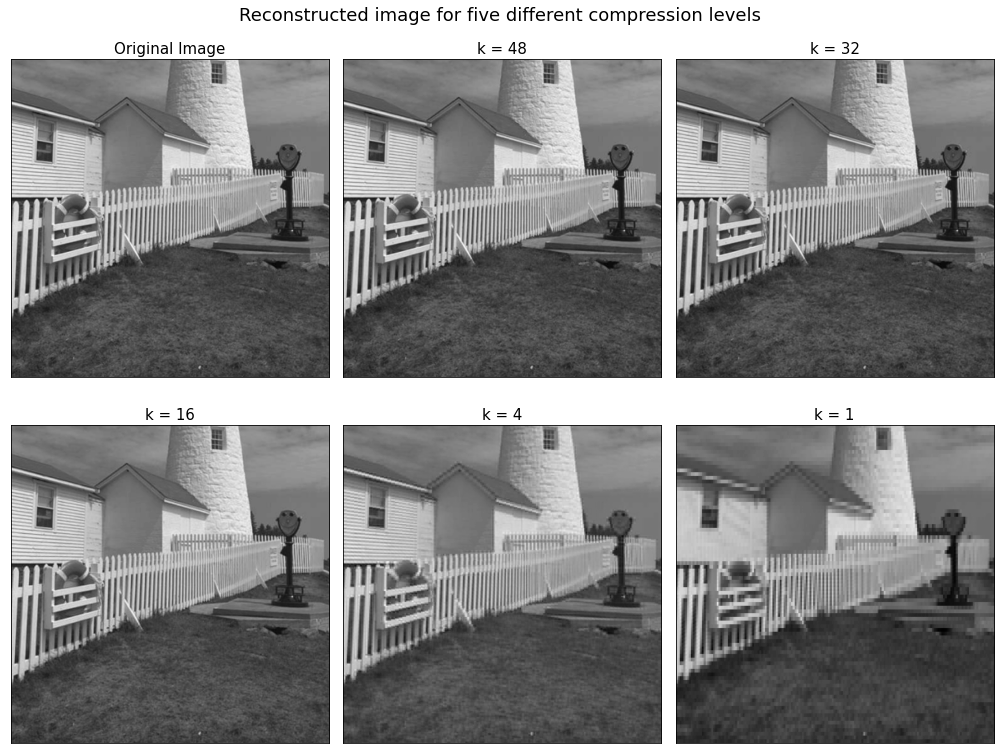

In [9]:
# Testing the image on 5 different compression levels

topk = [64, 48, 32, 16, 4, 1]
images = []
names = ['Original Image', 'k = 48', 'k = 32', 'k = 16', 'k = 4', 'k = 1']

for k in topk:
    images.append(compress_image_and_reconstruct(k))

fig = plt.figure(figsize = (14, 11))    
for i in range(len(images)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(names[i], size = 15)

plt.suptitle('Reconstructed image for five different compression levels', fontsize = 18)

fig.tight_layout()
plt.show()

From the above reconstructions, we can comment that PCA is effective in decorrelating the images. This is because the images reconstructed with $48$, $32$ and $16$ eigenvectors are almost as good as the original image. We can see slight blurring in the shed of the image with $4$ eigenvalues. And we can clearly observe blockiness if we use just $1$ eigenvalue. (See $k=1$ image). This indicates that even if we use just one eigenvalue, the lighthouse in reconstructed image is perceivable. Hence PCA is quite effectively decorrelating the features.

## Question 2 - Discrete Cosine Transform

Write a program to implement a JPEG-like image encoder using the following steps. 

### Encoder

In [10]:
# Divide the image into non-overlapping blocks of 8Ã—8 pixels

row_blocks = (688//8)
num_blocks = row_blocks ** 2

X = np.zeros((num_blocks, 8, 8))

for i in range(row_blocks):
    
    for j in range(row_blocks):
    
        start_i = 8 * i
        start_j = 8 * j
        block = lighthouse[start_i : start_i + 8, start_j : start_j + 8]

        X[row_blocks * i + j] = block
        

In [11]:
# Apply the Type-II DCT to each of the blocks.

def DCT(img):
    
    N,M = img.shape
    DCT = np.zeros((N,M))
    
    def C(num):
        if num==0:
            return 1/np.sqrt(2)
        else:
            return 1
    
    for u in range(N):
        for v in range(M):
            
            u_N = u * np.pi / (2 * N)
            v_M = v * np.pi / (2 * M)
            res = 0
            
            for i in range(N):
                cos_i = np.cos((2*i + 1) * u_N)
                for j in range(M):
                    cos_j = np.cos((2*j + 1) * v_M)
                    res += img[i][j] * cos_i * cos_j
                    
            DCT[u][v] = res * 4 * C(u) * C(v) / (N * M)
            
    return DCT

In [12]:
# Divide each block by the quantization matrix

def quantization(block):
    
    Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61], 
                 [12, 12, 14, 19, 26, 58, 60, 55],
                 [14, 13, 16, 24, 40, 57, 69, 56],
                 [14, 17, 22, 29, 51, 87, 80, 62],
                 [18, 22, 37, 56, 68, 109, 103, 77],
                 [24, 35, 55, 64, 81, 104, 113, 92],
                 [49, 64, 78, 87, 103, 121, 120, 101],
                 [72, 92, 95, 98, 112, 100, 103, 99]])
    
    return np.floor(np.divide(block, Q) + 0.5)

In [13]:
# Verifying if we are left with sparse coefficients

sample_block = X[0]
block_DCT = DCT(block)
quantized_block = quantization(block_DCT)

non_zero_vals = np.count_nonzero(quantized_block)
total = 64

print('Percentage of Non zero values : ', non_zero_vals / total * 100)

Percentage of Non zero values :  3.125


### Decoder

In [14]:
# Multiply each block with the inverse Q matrix

def inv_quant(block):
    
    Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61], 
                 [12, 12, 14, 19, 26, 58, 60, 55],
                 [14, 13, 16, 24, 40, 57, 69, 56],
                 [14, 17, 22, 29, 51, 87, 80, 62],
                 [18, 22, 37, 56, 68, 109, 103, 77],
                 [24, 35, 55, 64, 81, 104, 113, 92],
                 [49, 64, 78, 87, 103, 121, 120, 101],
                 [72, 92, 95, 98, 112, 100, 103, 99]])
    
    return np.multiply(Q, block)

In [15]:
# Apply the Type-II IDCT to each block.

def IDCT(img):
    
    N,M = img.shape
    IDCT = np.zeros((N,M))
    
    def C(num):
        if num==0:
            return 1/np.sqrt(2)
        else:
            return 1
    
    for i in range(N):
        for j in range(M):

            res = 0
            
            for u in range(N):
                u_N = u * np.pi / (2 * N)
                cos_i = np.cos((2*i + 1) * u_N)
                
                for v in range(M):
                    v_M = v * np.pi / (2 * M) 
                    cos_j = np.cos((2*j + 1) * v_M)
                    
                    res += img[u][v] * cos_i * cos_j
                    
            IDCT[i][j] = res * C(u) * C(v)
            
    return IDCT

In [16]:
# Put the sub-blocks together to generate the decoded estimate of the original image.

Decoded = np.zeros((688,688))

for i in range(num_blocks):
    
    block = X[i]
    block_DCT = DCT(block)
    quantized_block = quantization(block_DCT)
    
    unquantized = inv_quant(quantized_block)
    block_IDCT = IDCT(unquantized)
    
    row = 8 * (i // row_blocks)
    col = 8 * (i % row_blocks)
    
    Decoded[row : row+8, col : col+8] = block_IDCT

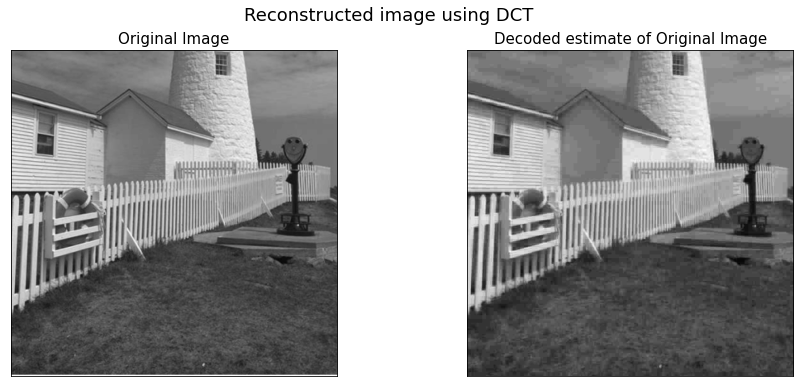

In [22]:
images = [lighthouse, Decoded]
names = ['Original Image', 'Decoded estimate of Original Image']

fig = plt.figure(figsize = (15,6)) 

for i in range(len(images)):
    plt.subplot(1, 2, i + 1)
    plt.imshow(images[i], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(names[i], size = 15)

plt.suptitle('Reconstructed image using DCT', fontsize = 18)

plt.show()

We can observe from the above images that there is some blockiness in the reconstructed image, but overall the image looks promising. Hence we can say that DCT is effective for image compression.